In [1]:
%pylab inline
#%matplotlib notebook
import xarray as xr
from glob import glob
from scipy import stats
import pandas as pd
#from xradd import *
from rrtmg_lw_functions import *
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
from string import ascii_lowercase
from scipy.interpolate import griddata
from netCDF4 import Dataset
import scipy.io
from scipy import interpolate
degree_sign= u'\N{DEGREE SIGN}'
import time
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


## Description

This notebook shows how I constructed profiles of cloud data for rrtmg.

The GEM 201308 run does not have effective radius information, so I needed to use a test GEM dataset from Zhipeng. This dataset is meteorology on 20210705, not the same run or time period as the GEM 201308 run.

I randomly picked a location where cloud data reaches ~150-100 hPa (very limited number of grid points satisfied this criteria) and directly use the data at that location.

### 0. Read pressure level data from base profiles for interpolation

In [2]:
indir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
ff = xr.open_dataset(indir+'idealized_gem_profiles_p_t_wv_perturb_base_radius_center_egde.nc')
p_grid = ff.P_ave.data[0,0,:][::-1]
px_grid = ff.P_lev.data[0,0,:][::-1]

### 1. Read the cloud data from test GEM dataset and find a location where cloud is high enough

In [3]:
indir = '/storage/xwang/transfer_data/data/GEM_1p0_new_raw/'
#indir = '/lustre03/project/6003571/zhipeng/transfer/GEM_rt/'
ff = xr.open_dataset(indir+'Test_data_2021070512_012_TOR.nc')
lat = ff.latitude.data
lon=ff.longitude.data

iwc0 = ff.water_content_ice.data/1000.#convert units from g/m3 to kg/m3
lwc0 = ff.water_content_rain.data/1000.#convert units from g/m3 to kg/m3
efi0 = ff.effective_radius_ice.data*1e6 # convert units from m to microns
efr0 = ff.effective_radius_rain.data*1e6 # convert units from m to microns
iwci = ff.implicit_cloud_solid_water_content.data/1000.#convert units from g/m3 to kg/m3
iwcr = ff.implicit_cloud_liquid_water_content.data/1000.#convert units from g/m3 to kg/m3
iwc0= iwc0+iwci
lwc0 = lwc0+iwcr

clf0 = ff.cloud_mask_3d.data
pp0 = ff.pressure_thermodynamic.data/100.

#### show the cross section of cloud ice and choose the location where cloud data reaches ~100 hPa

only these points: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


Text(0.5, 0, 'Longitude')

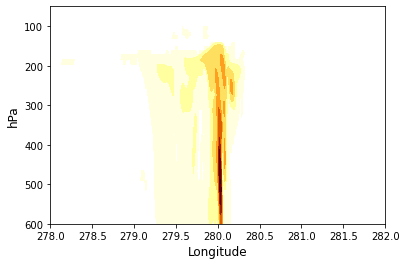

In [4]:
idxc=np.where(np.logical_and(clf0>0,iwc0>0))
iii = np.where(idxc[0]==idxc[0].min())[0] ### Find the highest position
print('only these points:',iii)
ilat = np.where(lat>=lat[idxc[1][iii]].mean())[0][0]

var= iwc0[:,ilat,:]*1.
var[var==0]=np.nan
plt.contourf(lon,pp0[:,ilat,700],var,cmap='afmhot_r')
plt.xlim([278,282])
plt.ylim([600,50])
plt.ylabel('hPa',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

Text(0.5, 0, 'IWC or cloud fraction units')

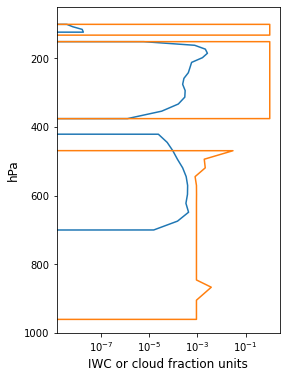

In [5]:
### Randomly pick one location among the 20 points
### Check the profiles at this location
ilat = np.where(lat>=lat[idxc[1][iii[4]]])[0][0]
ilon = np.where(lon>=lon[idxc[2][iii[4]]])[0][0]

fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(4,6, forward=True)

ax.plot(iwc0[:,ilat,ilon],pp0[:,ilat,ilon])
ax.plot(clf0[:,ilat,ilon],pp0[:,ilat,ilon])
# ax.plot(efi0[:,ilat,ilon],pp0[:,ilat,ilon])
# ax.plot(lwc0[:,ilat,ilon],pp0[:,ilat,ilon])
# ax.plot(efr0[:,ilat,ilon],pp0[:,ilat,ilon])

ax.set_ylim([1000,50])
ax.set_xscale('log')
ax.set_ylabel('hPa',fontsize=12)
ax.set_xlabel('IWC or cloud fraction units',fontsize=12)

### 2. The chosen location looks good. Now begin constructing the profiles for rrtmg

In [6]:
indir = '/storage/xwang/transfer_data/data/GEM_1p0_new_raw/'
ff = xr.open_dataset(indir+'Test_data_2021070512_012_TOR.nc')
iwc = ff.water_content_ice.isel(lat=ilat).isel(lon=ilon).data/1000.#convert units from g/m3 to kg/m3
lwc = ff.water_content_rain.isel(lat=ilat).isel(lon=ilon).data/1000.#convert units from g/m3 to kg/m3
efi = ff.effective_radius_ice.isel(lat=ilat).isel(lon=ilon).data*1e6 # convert units from m to microns
efr = ff.effective_radius_rain.isel(lat=ilat).isel(lon=ilon).data*1e6 # convert units from m to microns
iwci = ff.implicit_cloud_solid_water_content.isel(y=ilat).isel(x=ilon).data/1000.#convert units from g/m3 to kg/m3
iwcr = ff.implicit_cloud_liquid_water_content.isel(y=ilat).isel(x=ilon).data/1000.#convert units from g/m3 to kg/m3
iwc= iwc+iwci
lwc = lwc+iwcr

clf = ff.cloud_mask_3d.isel(lat=ilat).isel(lon=ilon).data
pp = ff.pressure_thermodynamic.isel(lat=ilat).isel(lon=ilon).data/100.

#### interpolate the cloud data onto pressure levels (the same pressure levels as the cleary sky profiles)

In [7]:
clf_grid=griddata(np.log(pp),clf,np.log(p_grid))
iwc_grid=griddata(np.log(pp),iwc,np.log(p_grid))
lwc_grid=griddata(np.log(pp),lwc,np.log(p_grid))
efi_grid=griddata(np.log(pp),efi,np.log(p_grid))
efr_grid=griddata(np.log(pp),efr,np.log(p_grid))

clf_grid[-1]=0 ### make the cloud fraction at the surface 0

#### Follow the layer/level scheme described in "3.0_GEM_vs_RRTMG_scheme_and_bias.ipynb"

In [8]:
data_type='above_150hPa' # 'above_150hPa','below_150hPa'

In [9]:
## this is for the profile WITH OVW cloud
if data_type=='above_150hPa':
    clf_tmp = clf_grid*1.
    clf = clf_tmp*1.
    clf[:-1]=clf_tmp[1:]

    iwc_mm = iwc_grid*1.
    iwc_mm[:-1]=iwc_grid[1:]
    lwc_mm = lwc_grid*1.
    lwc_mm[:-1]=lwc_grid[1:]*1.

    model_cld_data = iwc_mm,lwc_mm,efi_grid,efr_grid,clf,px_grid,0 
    iwc_data,lwc_data,eri_data,err_data, clf_data = form_cld_data(model_cld_data,attach_std_atmo=0)

In [10]:
## this is for the profile without OVW cloud
if data_type=='below_150hPa':
    ilev = np.where(p_grid>=150)[0][0]
    iwc_mm2 = iwc_mm*1.
    iwc_mm2[:ilev]=0
    lwc_mm2 = lwc_mm*1.
    lwc_mm2[:ilev]=0
    efi_grid2 = efi_grid*1.
    efi_grid2[:ilev]=0
    efr_grid2 = efr_grid*1.
    efr_grid2[:ilev]=0
    clf2 = clf*1.
    clf2[:ilev]=0

    model_cld_data = iwc_mm2,lwc_mm2,efi_grid2,efr_grid2,clf2,px_grid,0 # Best solution
    iwc_data,lwc_data,eri_data,err_data, clf_data = form_cld_data(model_cld_data,attach_std_atmo=0)

#### Store the data

Do not need to run the codes below unless you need to generate a new dataset.

In [37]:
# outdir = '/storage/xwang/transfer_data/data/heating_rate_result_data/'
# fout = Dataset(outdir+'idealized_gem_profiles_cloud_data_'+data_type+'.nc','w',format = 'NETCDF4')
# Level=fout.createDimension('level',77)
# nn=fout.createDimension('nn',1)
# nn2=fout.createDimension('nn2',2)

# outdata = fout.createVariable("iwc",'f4',('level'),zlib=True)
# outdata.units='kg/m3'
# outdata2 = fout.createVariable("lwc",'f4',('level'),zlib=True)
# outdata2.units='kg/m3'
# outdata3 = fout.createVariable("efi",'f4',('level'),zlib=True)
# outdata3.units='microns'
# outdata4 = fout.createVariable("efr",'f4',('level'),zlib=True)
# outdata4.units='microns'
# outdata5 = fout.createVariable("clf",'f4',('level'),zlib=True)
# outdata5.units='1'
# outdata6 = fout.createVariable("ems",'f4',('nn'),zlib=True)
# outdata7 = fout.createVariable("alb",'f4',('nn'),zlib=True)
# outdata8 = fout.createVariable("sza",'f4',('nn2'),zlib=True)

# Level=fout.createVariable("level",'f4',('level'),zlib=True)
# nn2=fout.createVariable("nn2",'f4',('nn2'),zlib=True)
# nn=fout.createVariable("nn",'f4',('nn'),zlib=True)

# outdata[:]=iwc_data
# outdata2[:]=lwc_data
# outdata3[:]=eri_data
# outdata4[:]=err_data
# outdata5[:]=clf_data
# outdata6[:]=emi_data
# outdata7[:]=alb_data
# outdata8[:]=sza_data

# Level[:]=np.arange(77)
# nn2[:] = np.array([0,40])
# nn[:] = np.array([0])
# fout.close()
